In [1]:
# use gpd_2023 environment

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pickle

import pandas as pd

# Test: Df to vol, vol to df

Lest check that we can load the df, create a volumn, and then recreate af df again

### Functions

In [2]:
def df_to_vol(df):
    """
    Converts a DataFrame into a 4D volume array for spatial-temporal data representation.
    The volume array is [height, width, n_months, n_features].

    Args:
        df (pd.DataFrame): The input DataFrame containing spatial-temporal data with columns
                           'abs_row', 'abs_col', 'abs_month', 'pg_id', 'col', 'row',
                           'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', and 'ln_os_best'.

    Returns:
        np.ndarray: The volume representation of the DataFrame with shape 
                    [n_months, height, width, n_features].
                    The specific shape will be [n_months, 180, 180, 8].
    """
    month_first = df['month_id'].min()
    month_last = df['month_id'].max()
    month_range = month_last - month_first + 1
    space_range = 180
    features_num = 8  # Should match the number of features in the DataFrame

    vol = np.zeros([space_range, space_range, month_range, features_num])

    vol[df['abs_row'], df['abs_col'], df['abs_month'], 0] = df['pg_id']
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 1] = df['col']
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 2] = df['row']
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 3] = df['month_id']
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 4] = df['c_id']
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 5] = df['ln_sb_best']
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 6] = df['ln_ns_best']
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 7] = df['ln_os_best']

    vol = np.flip(vol, axis=0)  # Flip the rows, so north is up.
    vol = np.transpose(vol, (2, 0, 1, 3))  # Move the month dimension to the front.

    print(f'Volume of shape {vol.shape} created. Should be (n_months, 180, 180, 8)')

    return vol


In [3]:
def vol_to_df(vol):
    """
    Converts a 4D volume array back into a DataFrame for spatial-temporal data.
    The volume array is expected to have dimensions [n_months, height, width, n_features].

    Args:
        vol (np.ndarray): The input 4D volume array to be converted, with shape 
                          [n_months, height, width, n_features].

    Returns:
        pd.DataFrame: The DataFrame representation of the volume array containing columns
                      'pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best'.
                      DataFrame is cleaned to remove rows where 'pg_id' is 0.
    """
    n_months, height, width, n_features = vol.shape

    df = pd.DataFrame({
        'pg_id': vol[:, :, :, 0].flatten(),
        'col': vol[:, :, :, 1].flatten(),
        'row': vol[:, :, :, 2].flatten(),
        'month_id': vol[:, :, :, 3].flatten(),
        'c_id': vol[:, :, :, 4].flatten(),
        'ln_sb_best': vol[:, :, :, 5].flatten(),
        'ln_ns_best': vol[:, :, :, 6].flatten(),
        'ln_os_best': vol[:, :, :, 7].flatten()
    })

    # Correct the data types
    df['pg_id'] = df['pg_id'].astype(int)
    df['col'] = df['col'].astype(int)
    df['row'] = df['row'].astype(int)
    df['month_id'] = df['month_id'].astype(int)
    df['c_id'] = df['c_id'].astype(int)

    # Remove rows where 'pg_id' is 0
    df = df[df['pg_id'] != 0]

    print(f'DataFrame of shape {df.shape} created. Should be (n_months * 180 * 180, 8)')

    return df


In [4]:
def df_vol_test(df, vol):
    """
    Unit test to verify the conversion between DataFrame and volume array.
    Checks if the original DataFrame and the DataFrame created from the volume are equivalent.

    Args:
        df (pd.DataFrame): The original DataFrame.
        vol (np.ndarray): The 4D volume array created from the DataFrame.

    Returns:
        None: Prints the result of the equivalence test.
    """
    # Make a copy of the original DataFrame
    df_copy = df.copy()

    # Proof of concept: Check if the copy is the same as the original
    print("Original DataFrame equals its copy:", df.equals(df_copy))

    # Convert the volume back into a DataFrame
    df_recreated = vol_to_df(vol)

    # Trim the original DataFrame to match the features of the recreated DataFrame
    df_trimmed = df[['pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best']]

    # Sort both DataFrames by 'pg_id' and 'month_id'
    df_trimmed = df_trimmed.sort_values(by=['pg_id', 'month_id'])
    df_recreated = df_recreated.sort_values(by=['pg_id', 'month_id'])

    # Reset the index to ensure alignment
    df_trimmed = df_trimmed.reset_index(drop=True)
    df_recreated = df_recreated.reset_index(drop=True)

    # Check if the two DataFrames are the same
    is_equal = df_trimmed.equals(df_recreated)
    print("Trimmed original DataFrame equals recreated DataFrame from volume:", is_equal)


### Execute


In [5]:
# set the path to the raw data
PATH = "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/raw/calibration_viewser_data.pkl"

# get the df from the pickle file in raw_data
df = pd.read_pickle(PATH)

# turn the df1 into a volume
vol = df_to_vol(df)

df_vol_test(df, vol)

Volume of shape (324, 180, 180, 8) created. Should be (n_months, 180, 180, 8)
Original DataFrame equals its copy: True
DataFrame of shape (4247640, 8) created. Should be (n_months * 180 * 180, 8)
Trimmed original DataFrame equals recreated DataFrame from volume: True


# forecast storage test
Now we test how we can make a storage array for the 4D forcast

### Functions

In [6]:
def generate_fake_vol(vol, month_range=32):
    """
    Generates a fake prediction volume for testing purposes by extracting the last three features from the input volume.
    Assumes the last three features represent `sb`, `ns`, and `os`.

    Args:
        vol (np.ndarray): The input 4D volume array with shape [n_months, height, width, n_features].
        n_months (int): The number of months to include in the fake volume. Default is 32.

    Returns:
        np.ndarray: A volume array with the last three features, shape [32, height, width, 3].
                    Represents a subset of the original volume for testing.
    """
    # Extract the last three features from the volume
    fake_vol = vol[:month_range, :, :, 5:]  

    return fake_vol


In [7]:
def make_forecast_storage_vol(df, month_range):
    """
    Creates a forecast storage volume based on the last month of data in the DataFrame.
    The volume is repeated for the specified `month_range` with incrementally adjusted month IDs.

    Args:
        df (pd.DataFrame): The input DataFrame containing spatial-temporal data.
                           Expected columns include 'abs_row', 'abs_col', 'abs_month', 'pg_id', 'col', 
                           'row', 'month_id', 'c_id'.
        month_range (int): The number of months to forecast into the future.

    Returns:
        np.ndarray: The forecast storage volume with shape [month_range, 180, 180, 5].
                    Each time slice in the volume represents a future month based on the last month of data.
    """
    # Infer the last month_id from the DataFrame
    last_month_id = df['month_id'].max()

    # Create a sub DataFrame of only the last month
    sub_df = df[df['month_id'] == last_month_id].copy()

    # Initialize the volume array
    space_range = 180
    features_num = 5  # Adjust this based on the number of features you have

    # Create the zero array with only the last month
    vol = np.zeros([space_range, space_range, 1, features_num])

    # Adjust abs_month to 0 for the initial volume
    sub_df['adjusted_abs_month'] = 0

    # Populate the volume array with the data from the DataFrame
    vol[sub_df['abs_row'], sub_df['abs_col'], sub_df['adjusted_abs_month'], 0] = sub_df['pg_id']
    vol[sub_df['abs_row'], sub_df['abs_col'], sub_df['adjusted_abs_month'], 1] = sub_df['col']
    vol[sub_df['abs_row'], sub_df['abs_col'], sub_df['adjusted_abs_month'], 2] = sub_df['row']
    vol[sub_df['abs_row'], sub_df['abs_col'], sub_df['adjusted_abs_month'], 3] = sub_df['month_id'] 
    vol[sub_df['abs_row'], sub_df['abs_col'], sub_df['adjusted_abs_month'], 4] = sub_df['c_id']

    # Stack the volume to the desired month range
    vol = np.repeat(vol, month_range, axis=2)

    # Adjust the month_id with an increment of 1
    for i in range(month_range):
        vol[:, :, i, 3] = last_month_id + i

    # Reorient and transpose
    vol = np.flip(vol, axis=0)
    vol = np.transpose(vol, (2, 0, 1, 3))

    print(f'Volume of shape {vol.shape} created. Should be ({month_range}, 180, 180, {features_num})')

    return vol

In [9]:
def merge_vol(vol, vol_fake):
    """
    Merges a forecast volume with an existing forecast storage volume.
    Combines the features from `vol_fake` with `vol` along the feature axis.

    Args:
        vol (np.ndarray): The forecast storage volume with shape [n_months, height, width, n_features].
        vol_fake (np.ndarray): The forecast volume to be merged with shape [n_months, height, width, n_features_fake].

    Returns:
        np.ndarray: The merged volume with shape [n_months, height, width, n_features + n_features_fake].
    """
    # Merge the forecast volume with the storage volume along the feature axis
    full_vol = np.concatenate([vol, vol_fake], axis=-1)

    return full_vol


In [12]:
def plot_volume_slices(volume, num_slices=32):
    """
    Plots slices of the 4D volume array, displaying different feature maps for each time step.

    Args:
        volume (np.ndarray): The input 4D volume array with shape [n_months, height, width, n_features].
                             Expects the first dimension to represent time steps.
        num_slices (int): The number of slices (time steps) to plot. Default is 32.

    Returns:
        None: Displays the plots.
    """
    features_titles = ['pg_id', 'col', 'row', 'Month ID', 'c_id', 'sb', 'ns']

    for i in range(num_slices):
        fig, ax = plt.subplots(1, 7, figsize=(20, 6))
        
        for j in range(min(7, volume.shape[-1])):  # Handle cases where there are fewer than 7 features
            im = ax[j].imshow(volume[i, :, :, j], cmap='rainbow', vmin= volume[:, :, :, j].min(), vmax= volume[:, :, :, j].max())
            ax[j].set_title(features_titles[j] if j < len(features_titles) else f'Feature {j}')
            #plt.colorbar(im, ax=ax[j])

        fig.suptitle(f'Time Step {i + 1}', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


### Execute

(32, 180, 180, 3)
Volume of shape (32, 180, 180, 5) created. Should be (32, 180, 180, 5)
(32, 180, 180, 5)
(32, 180, 180, 8)


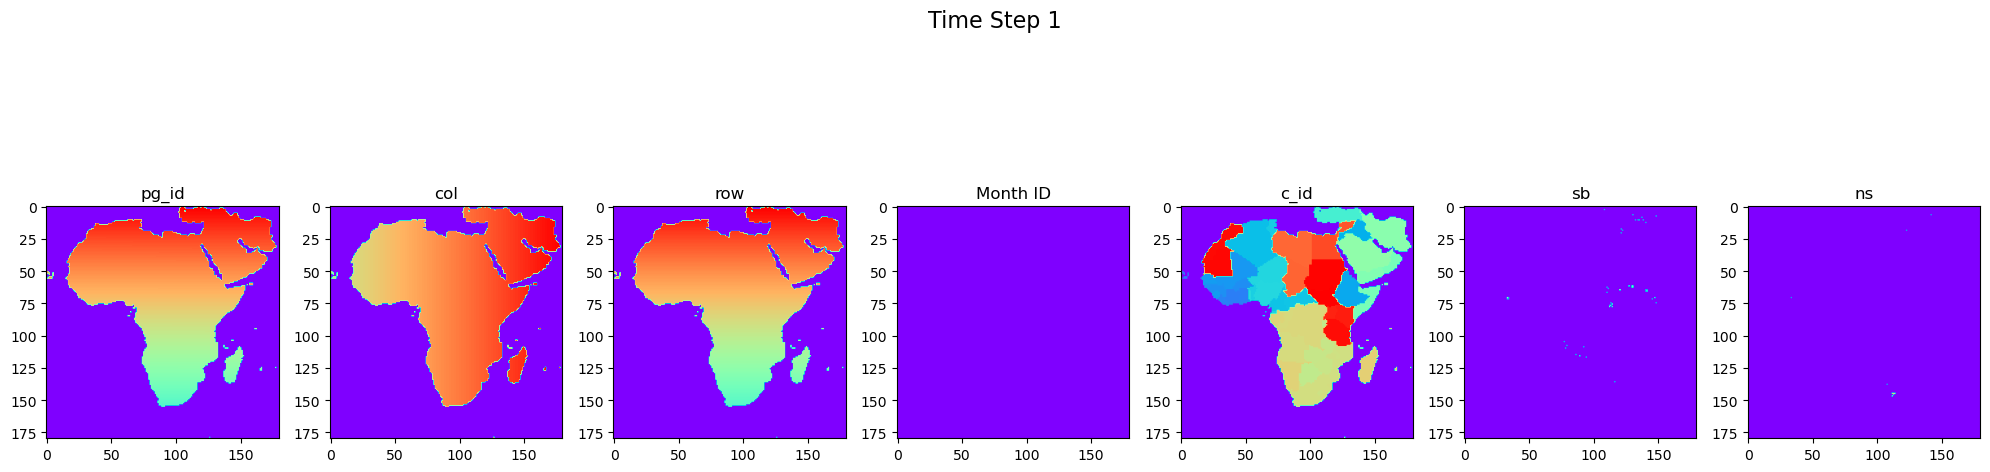

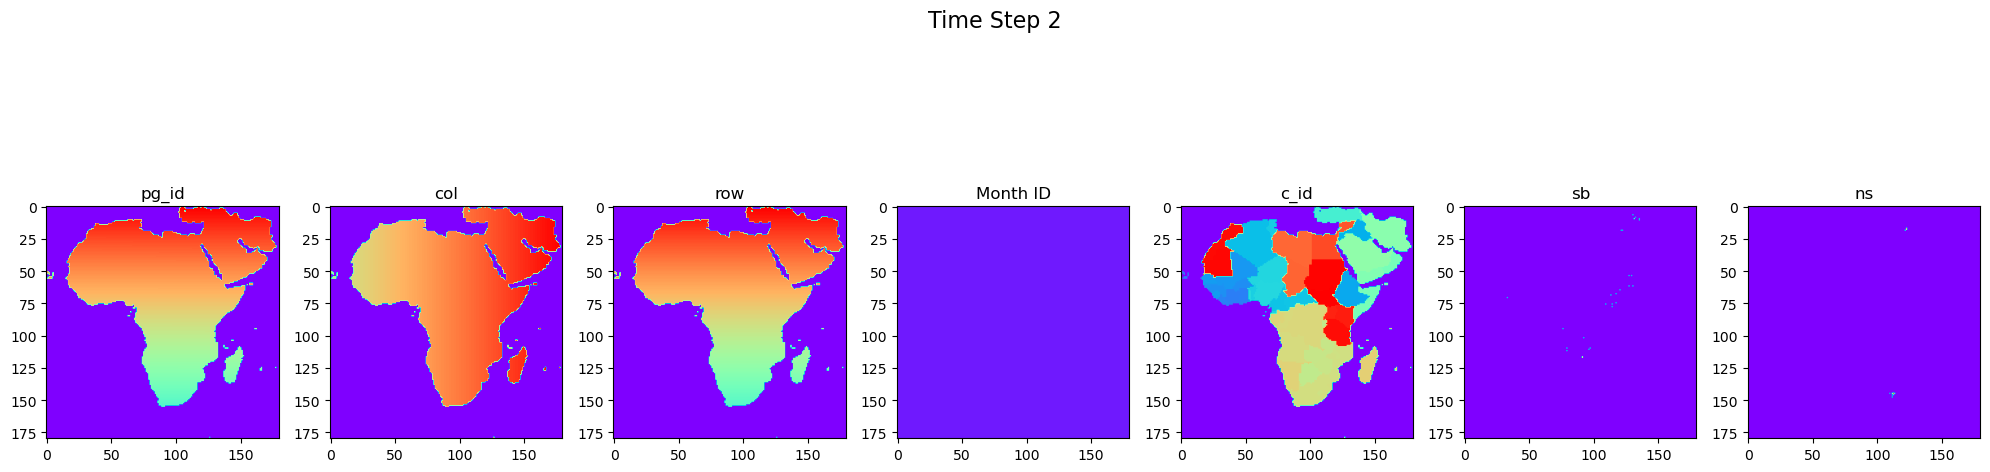

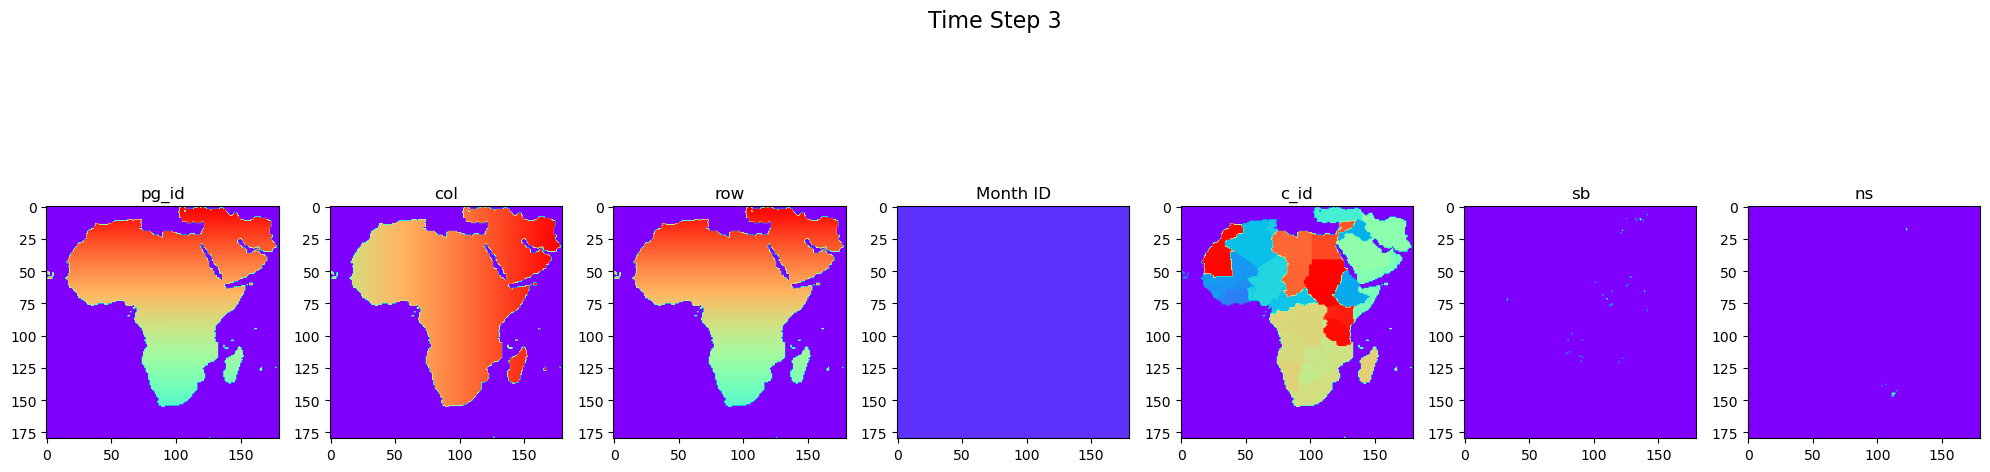

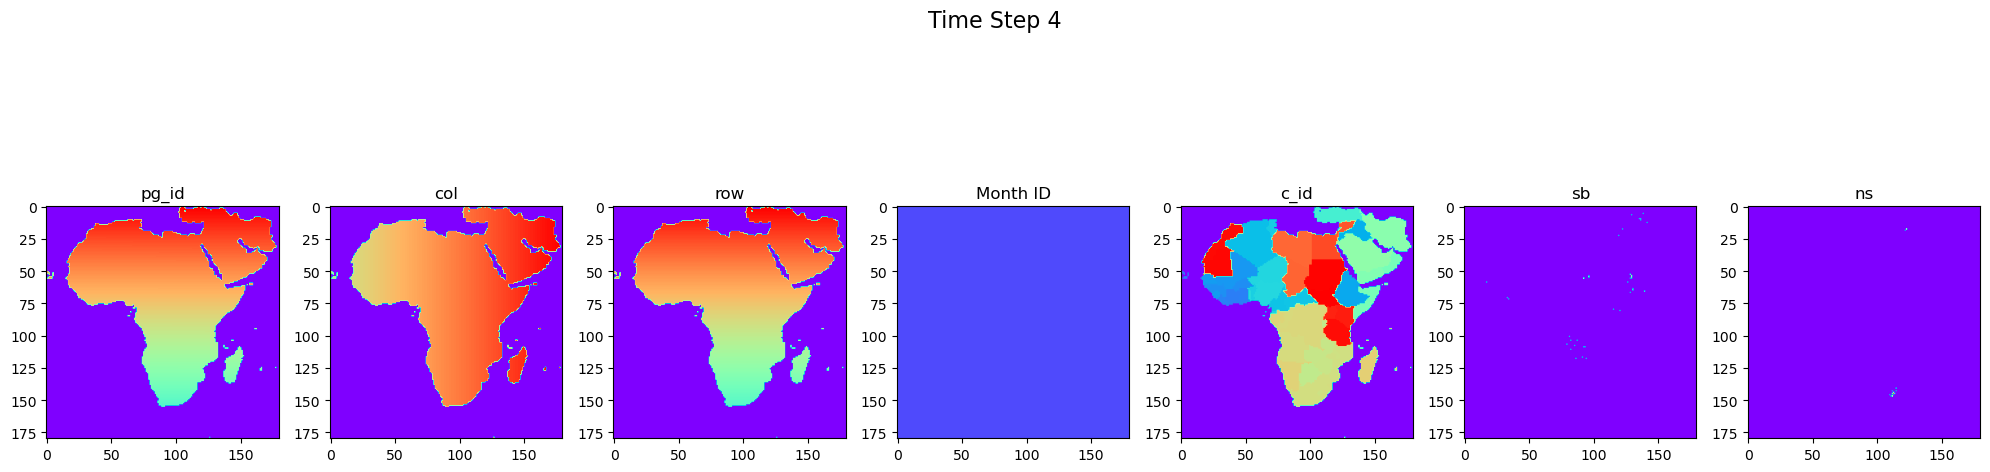

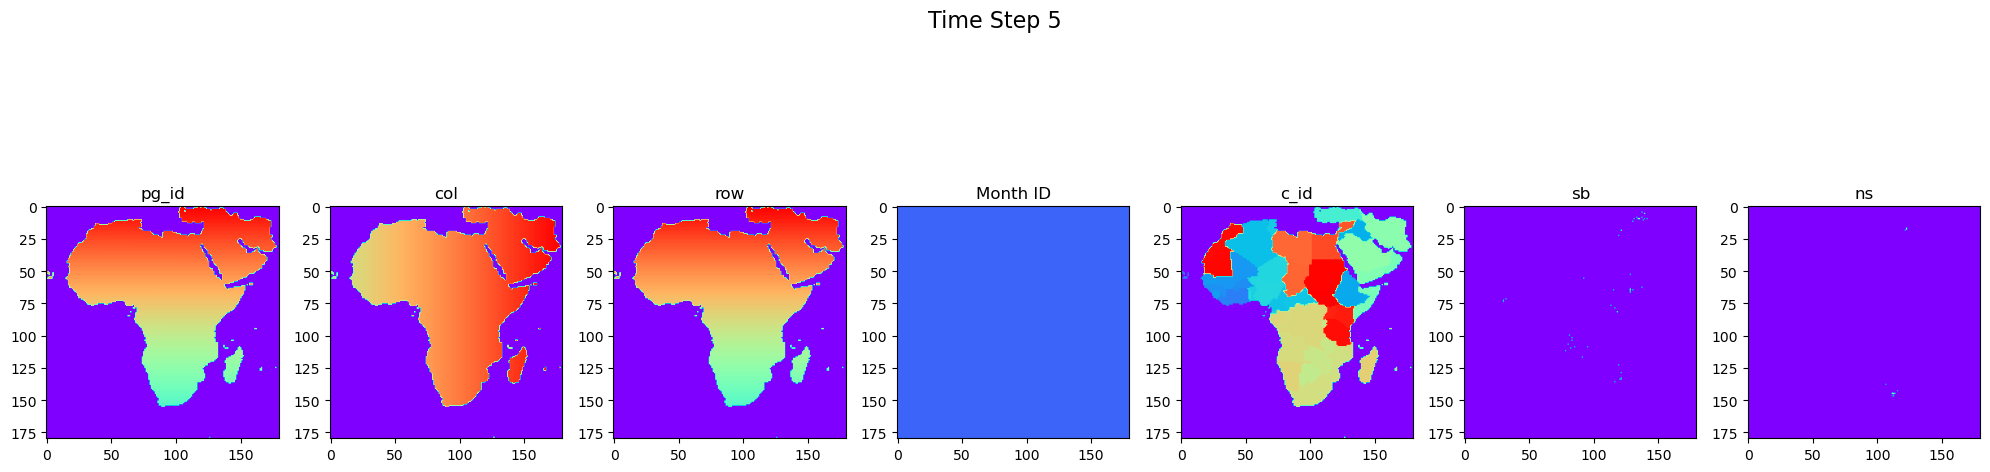

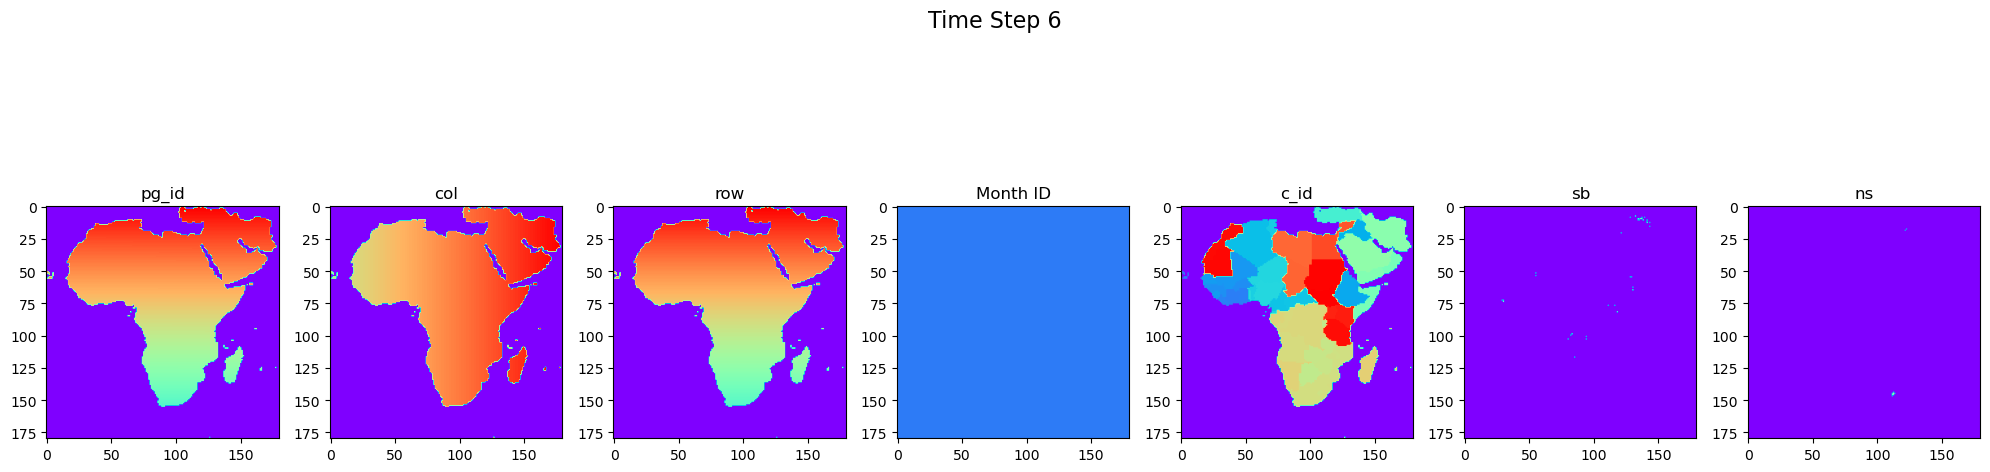

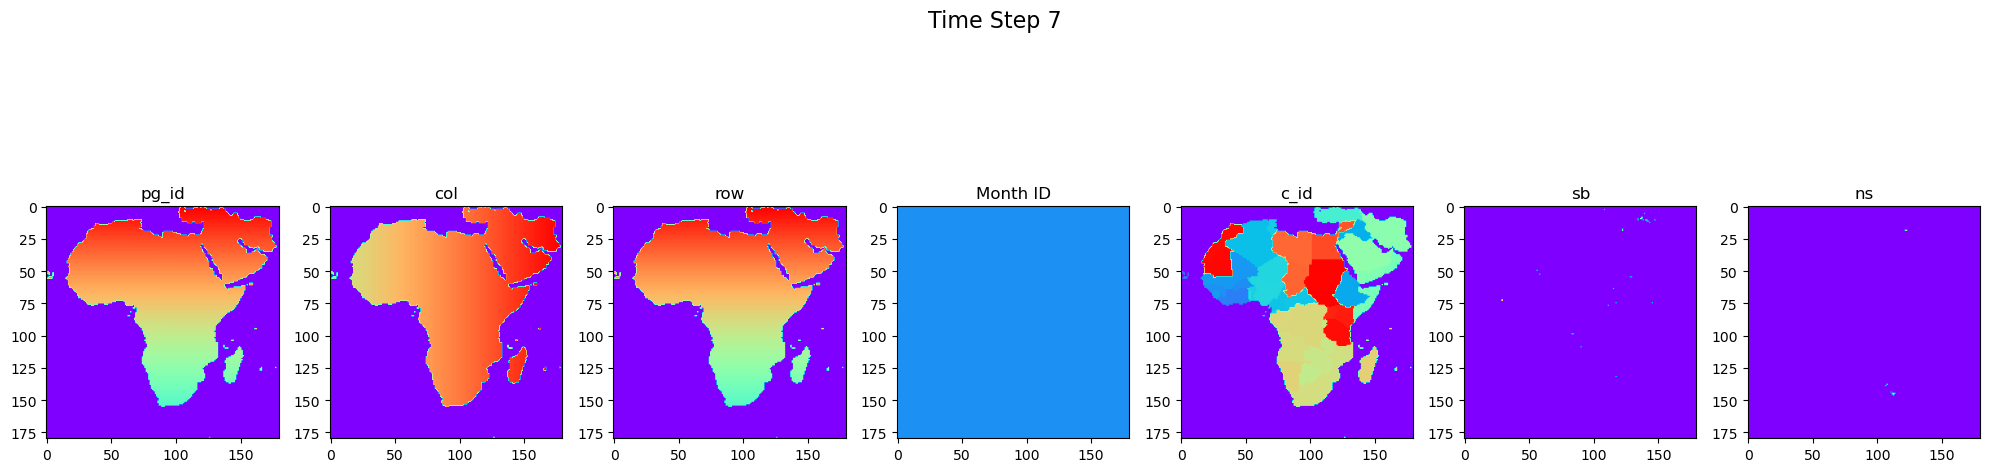

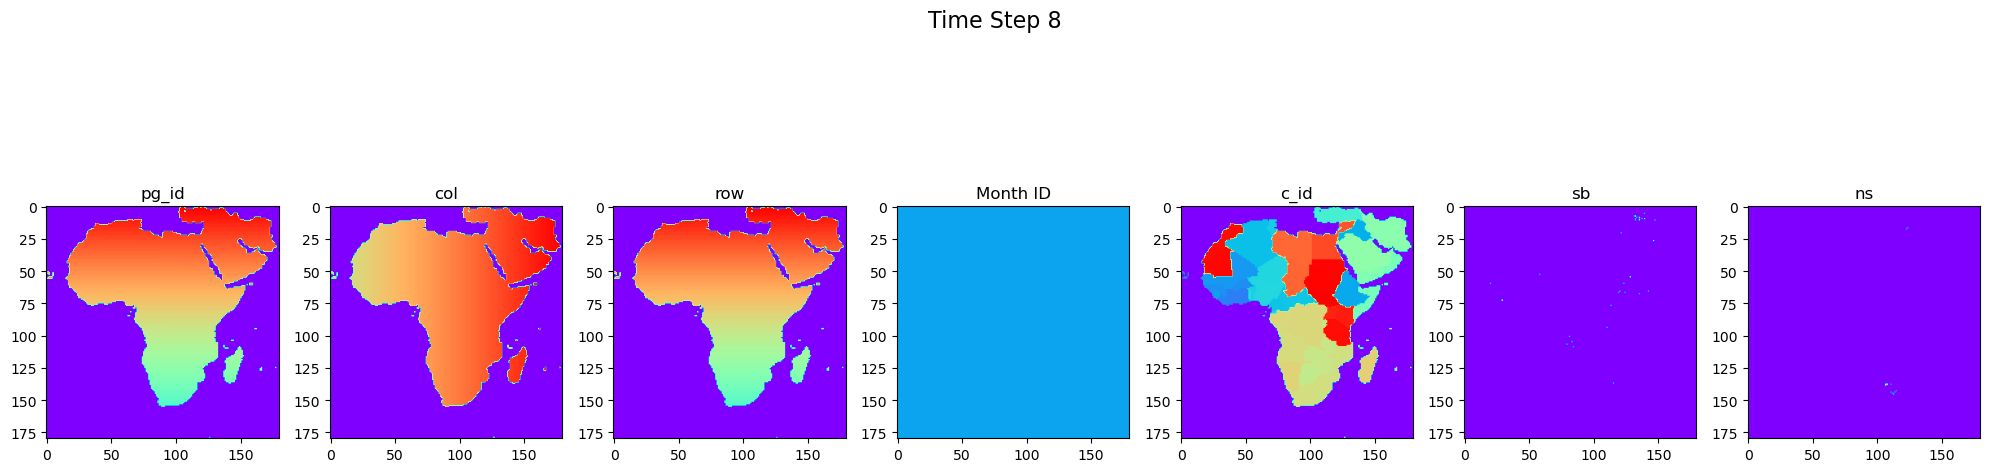

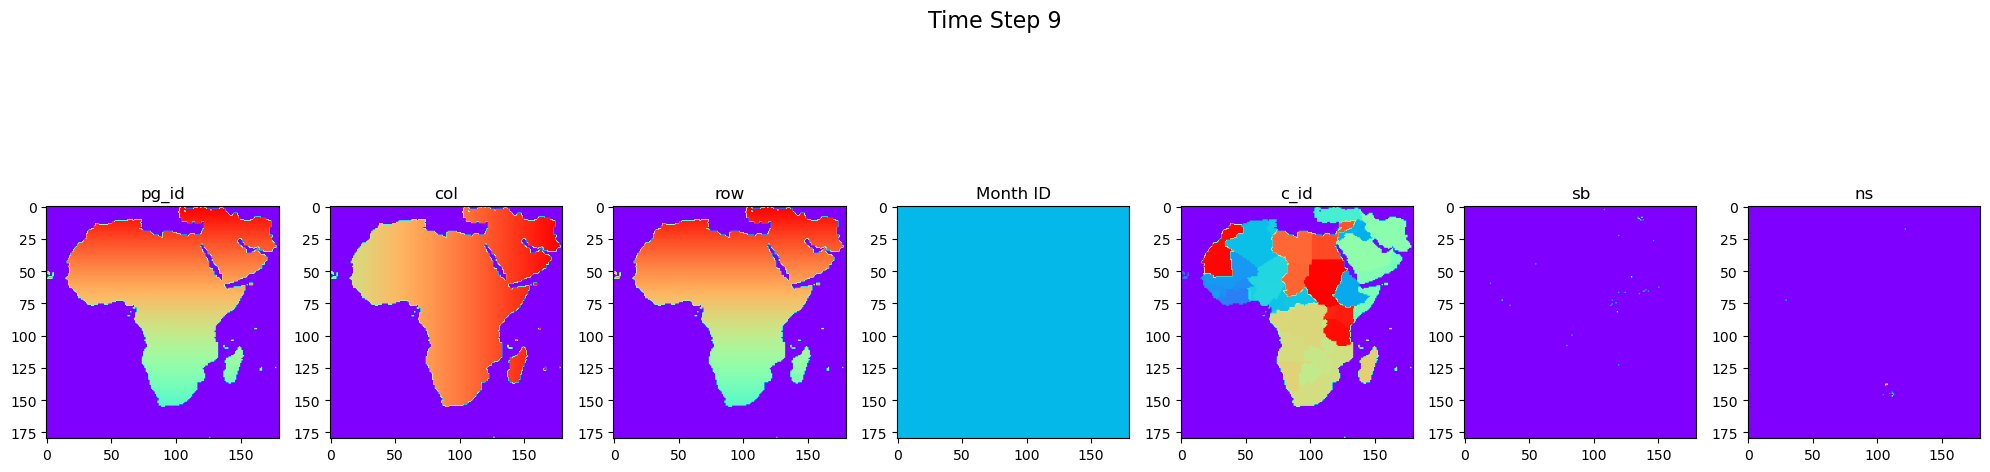

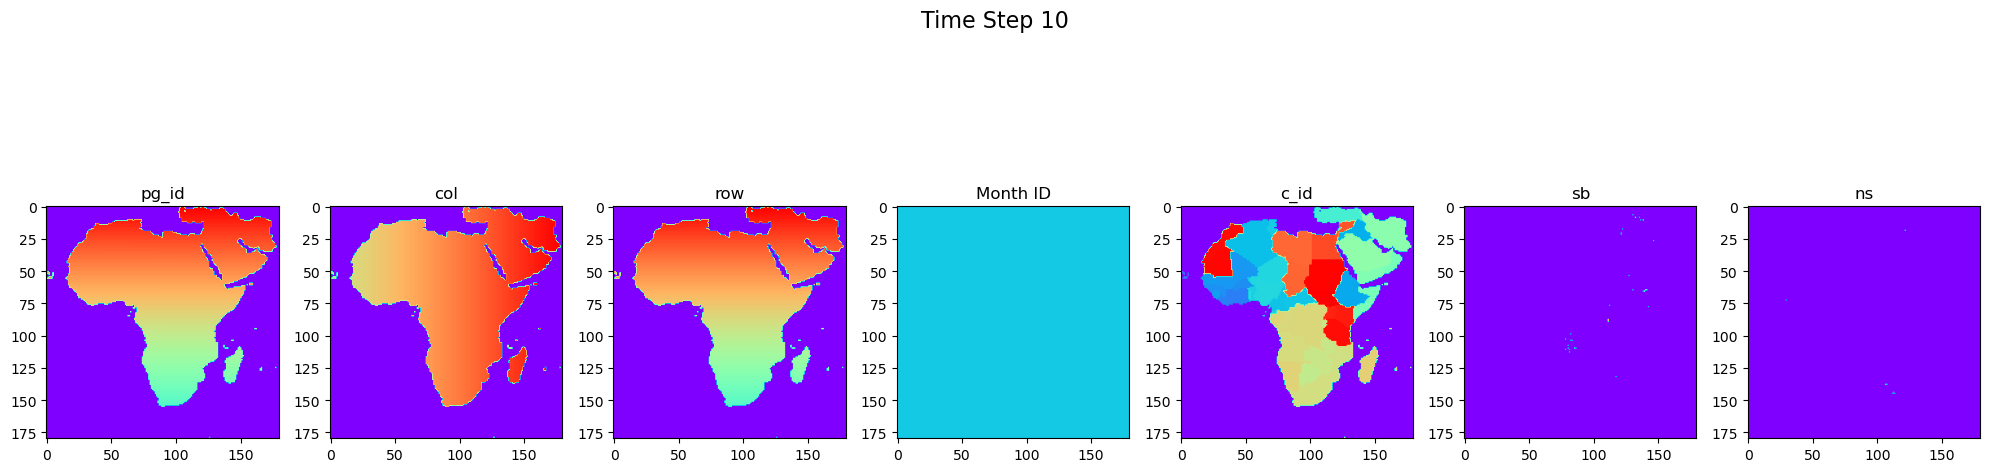

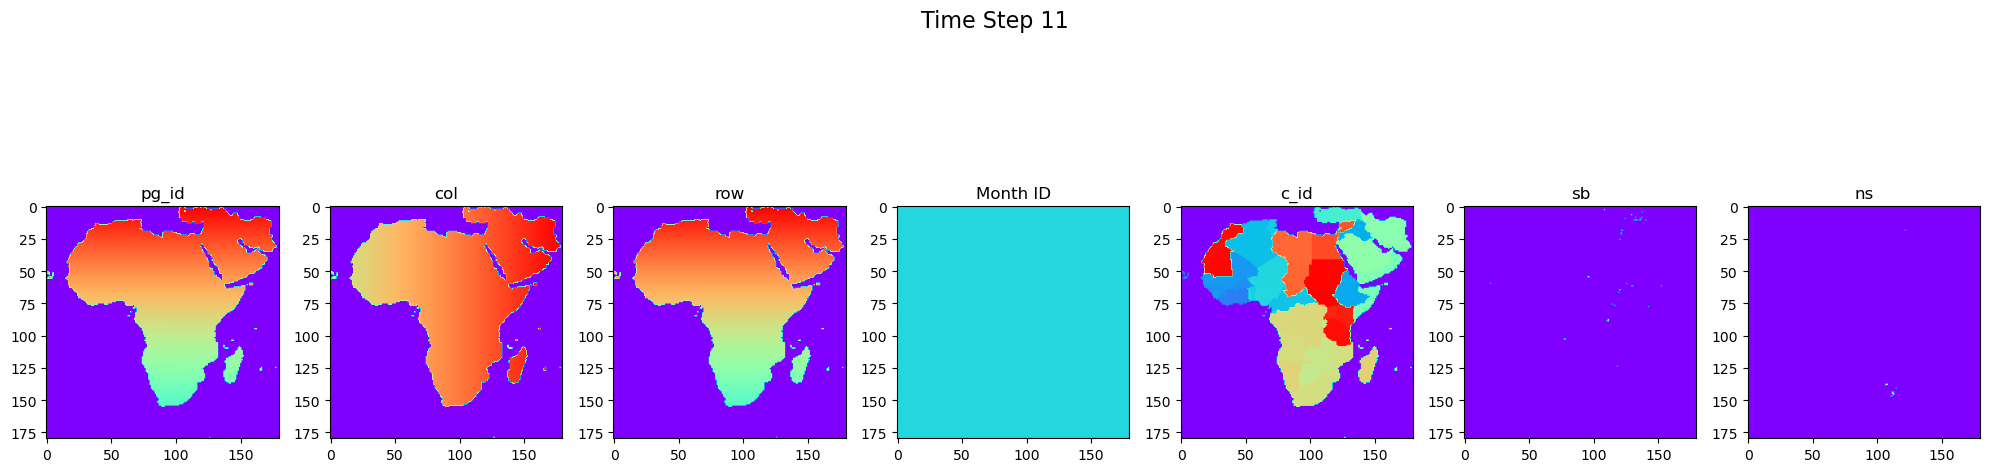

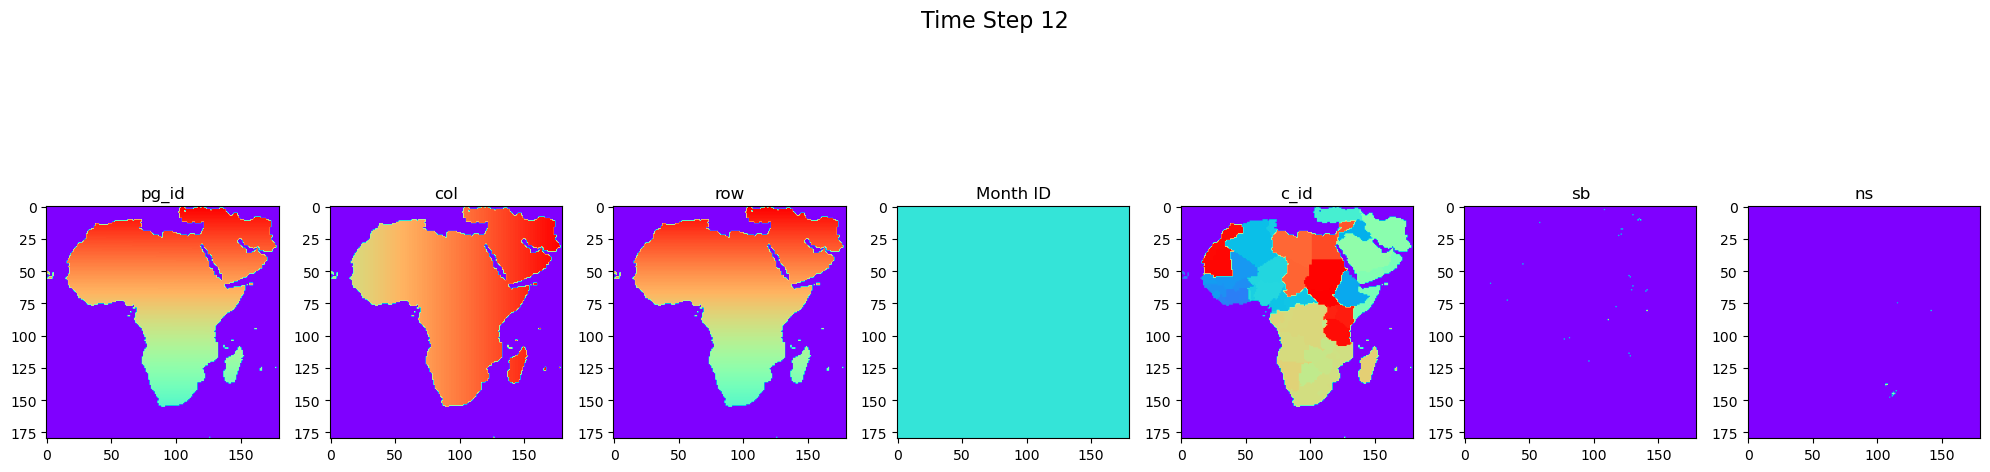

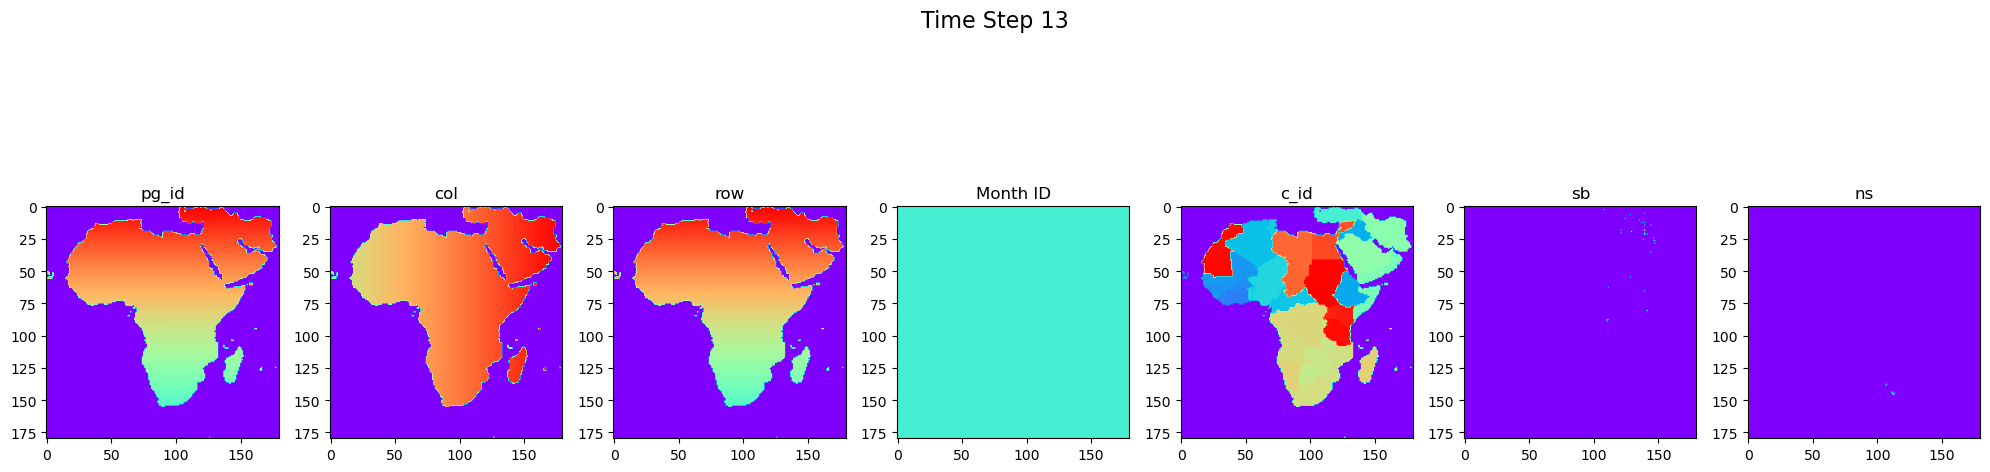

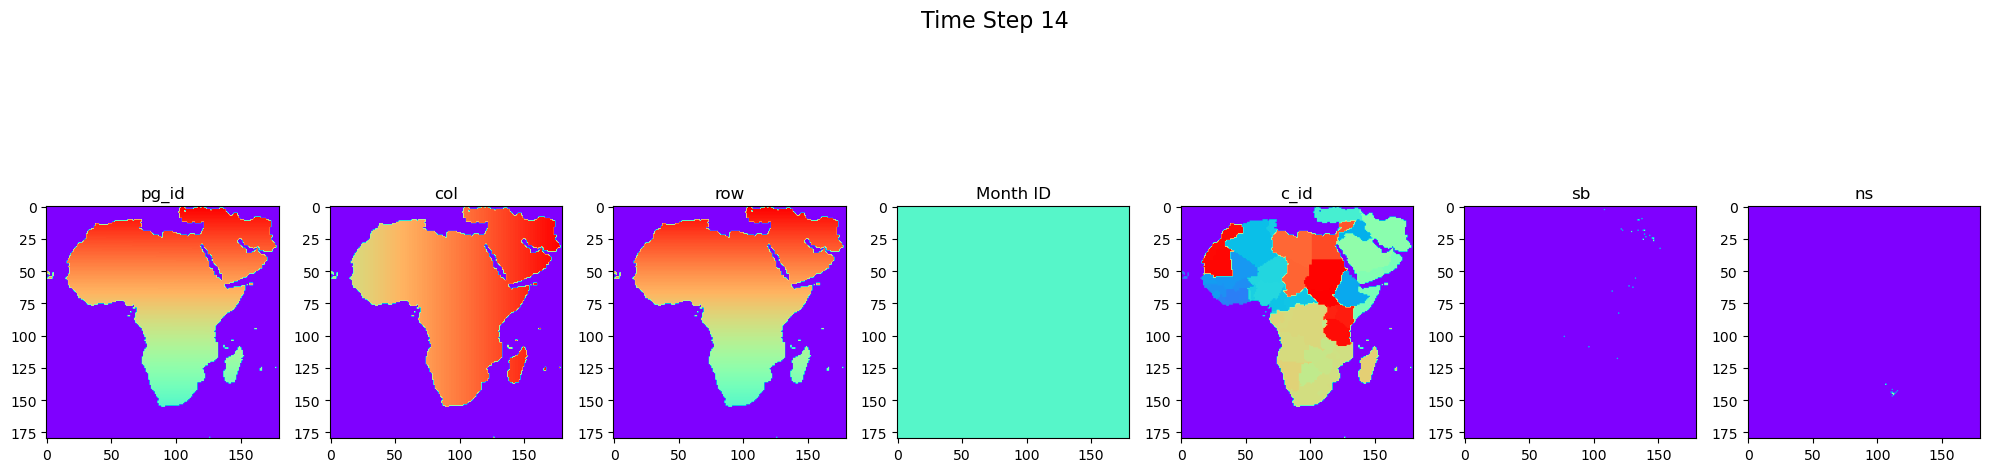

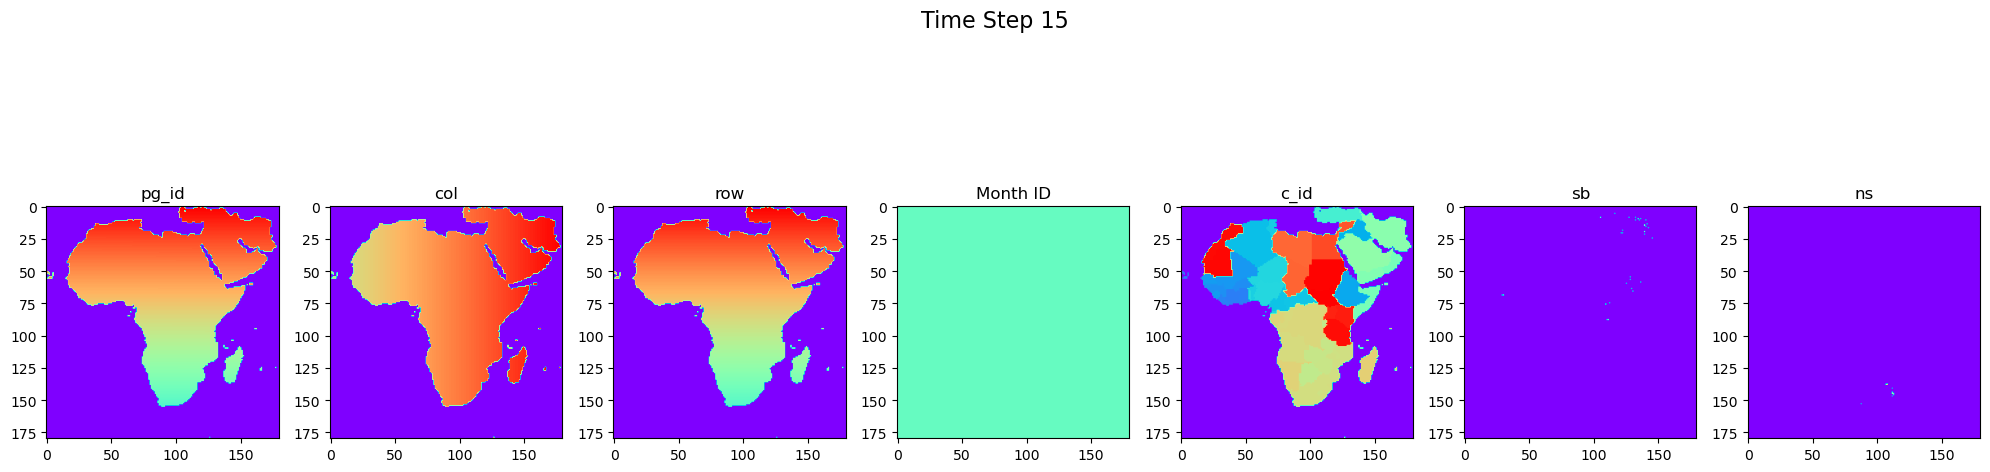

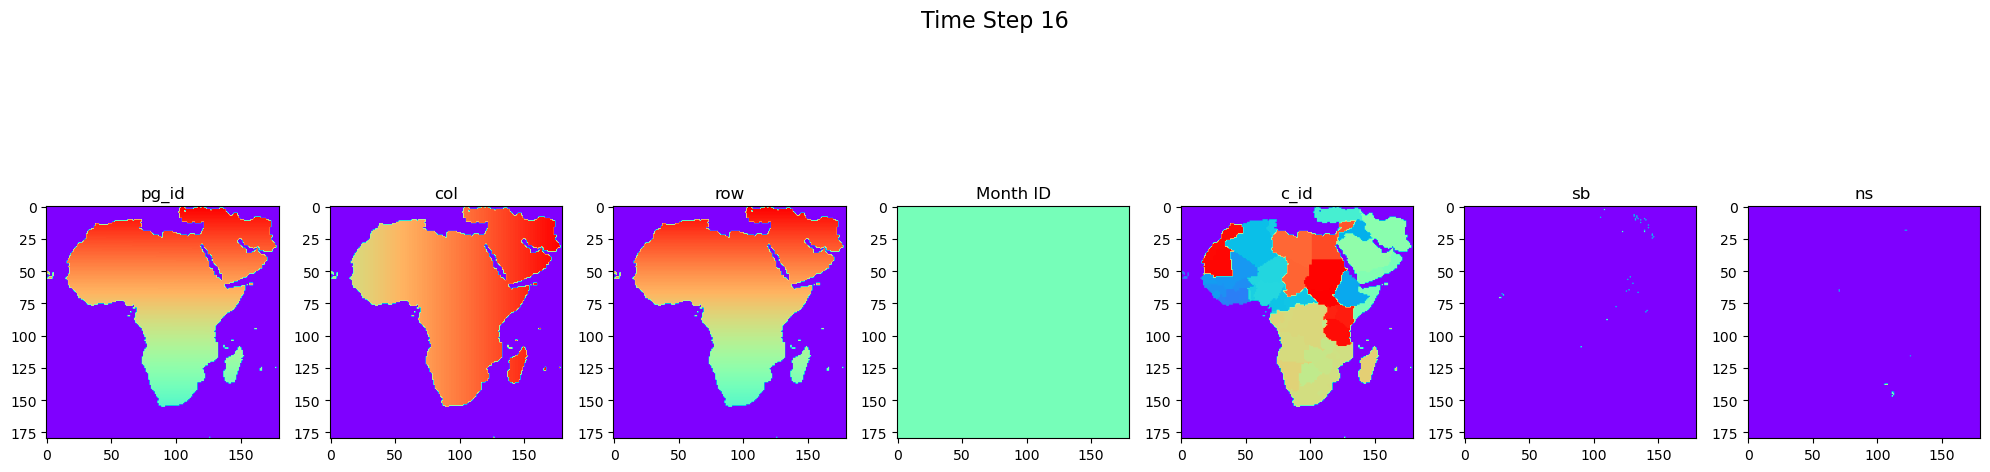

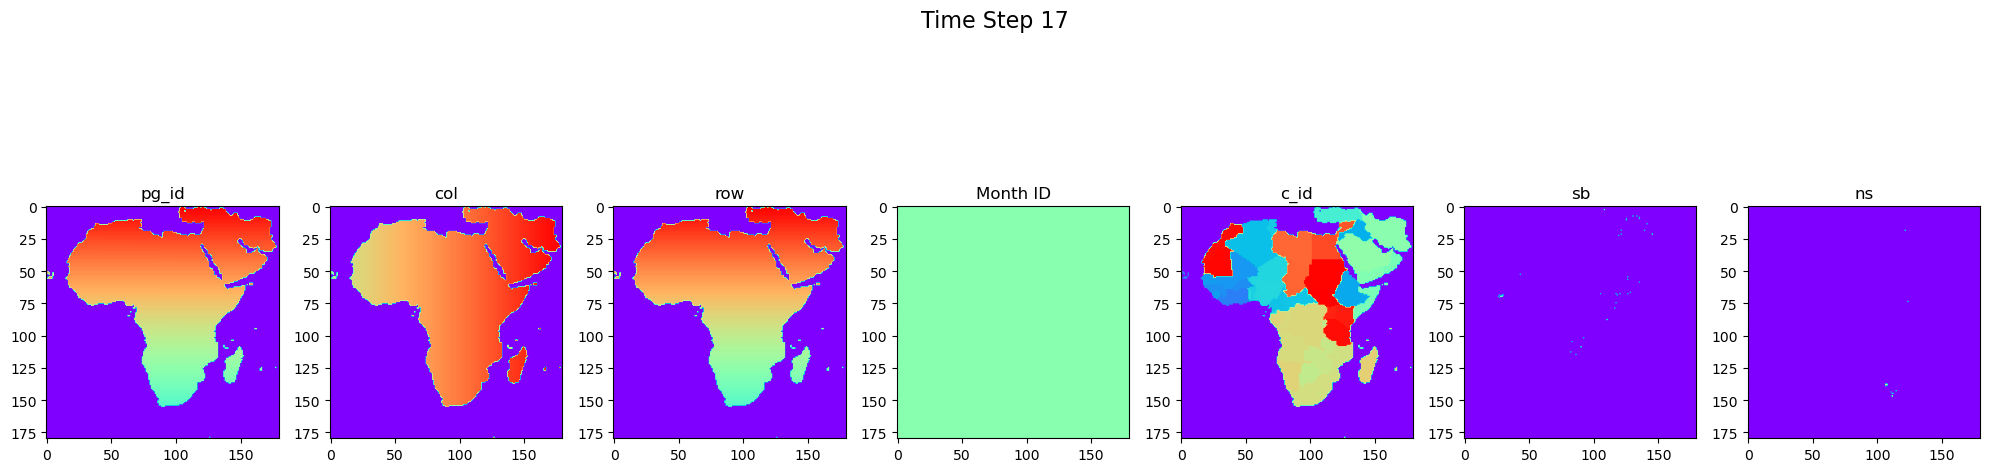

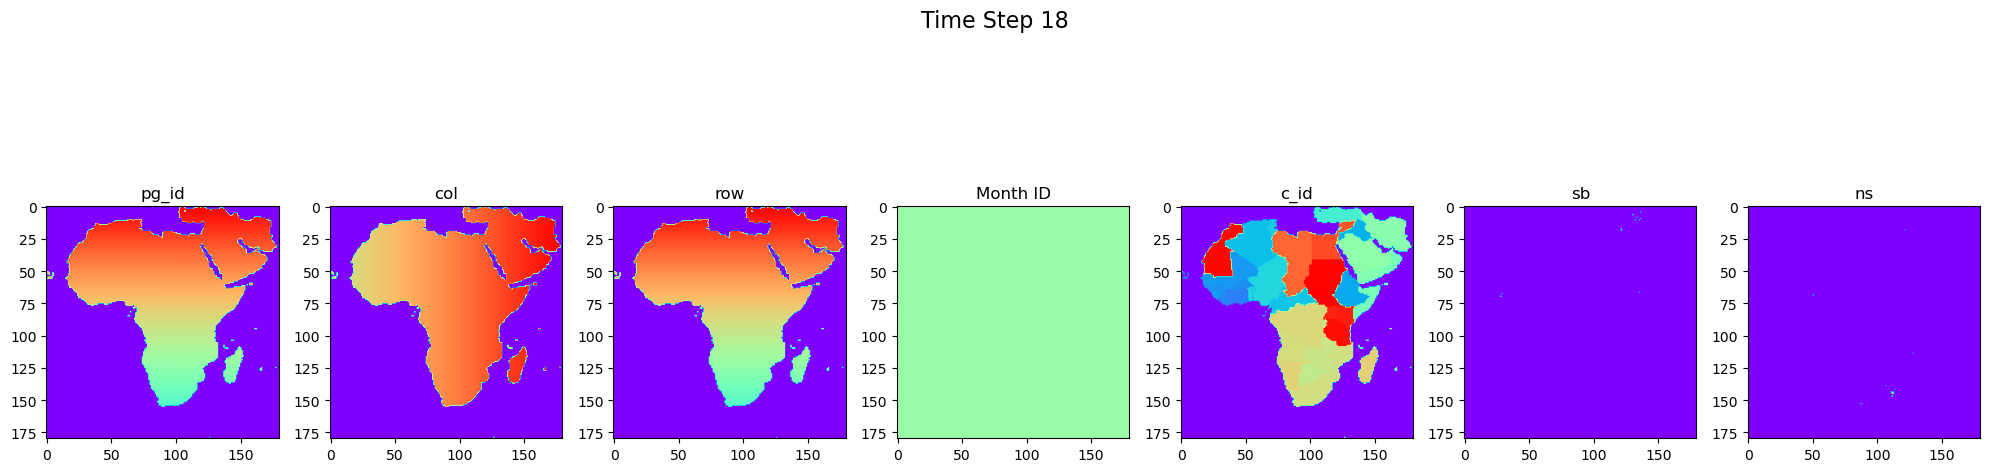

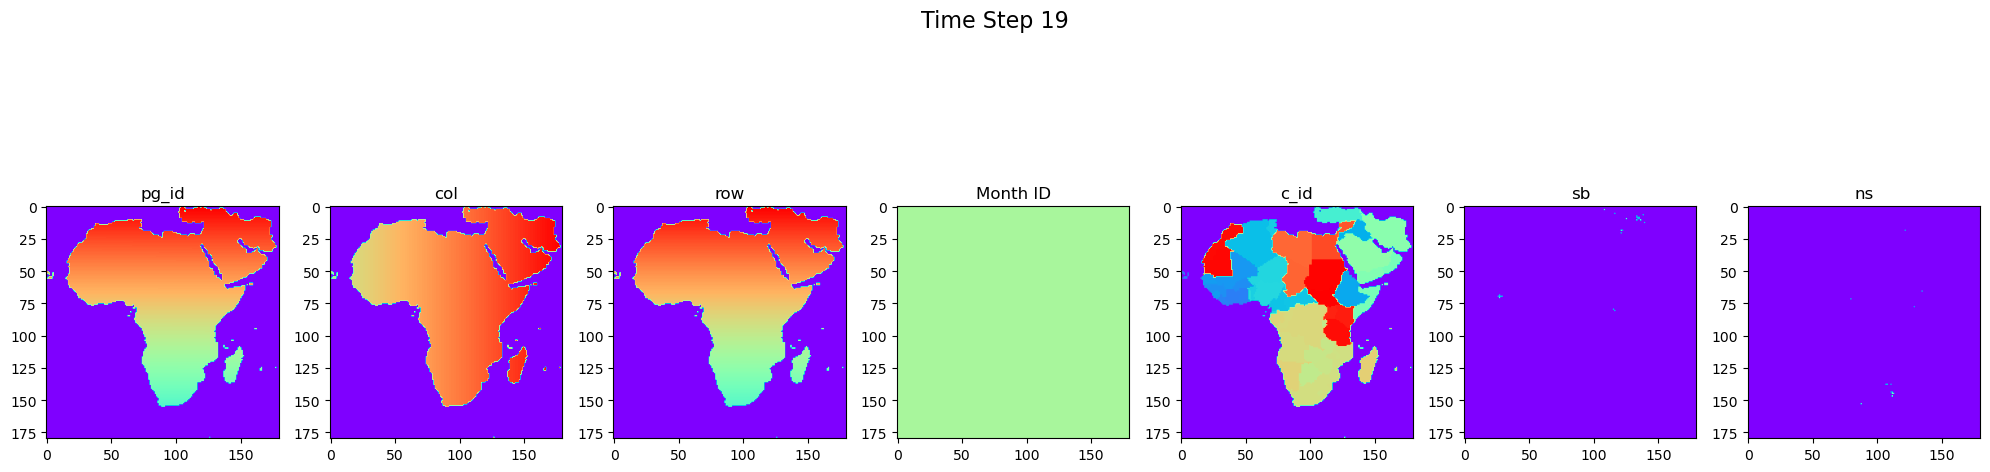

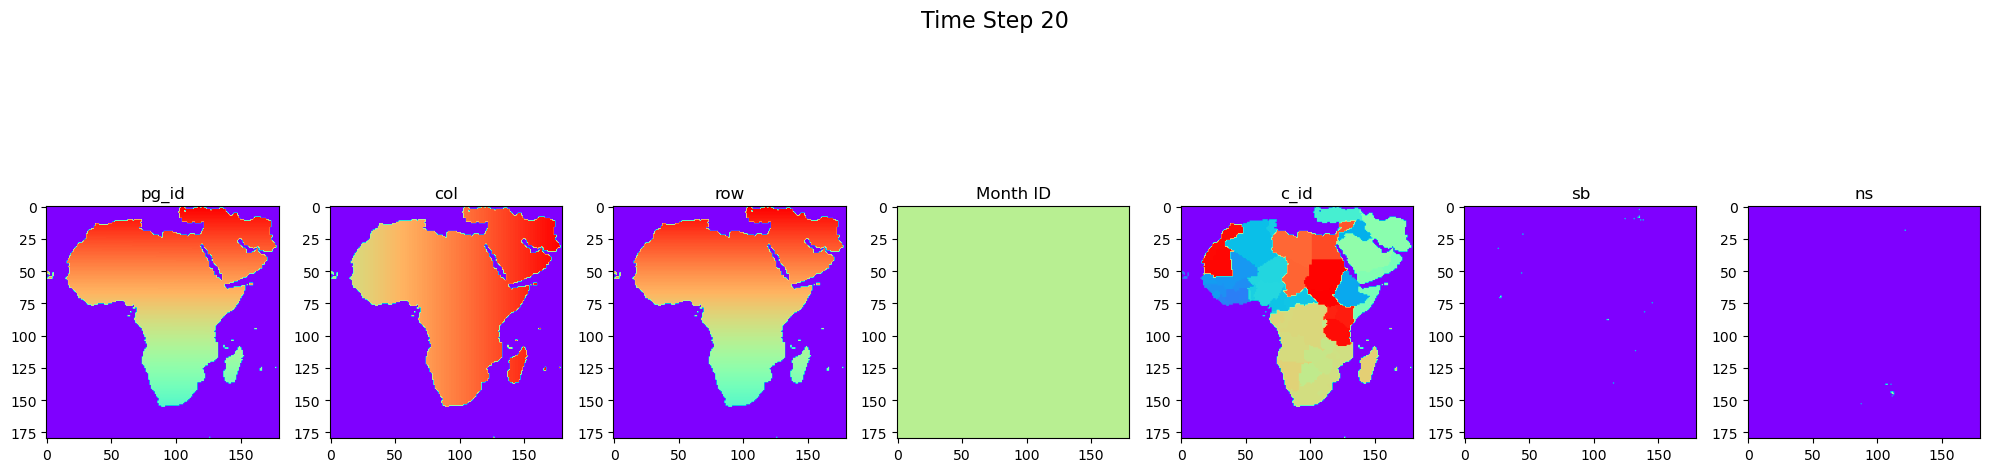

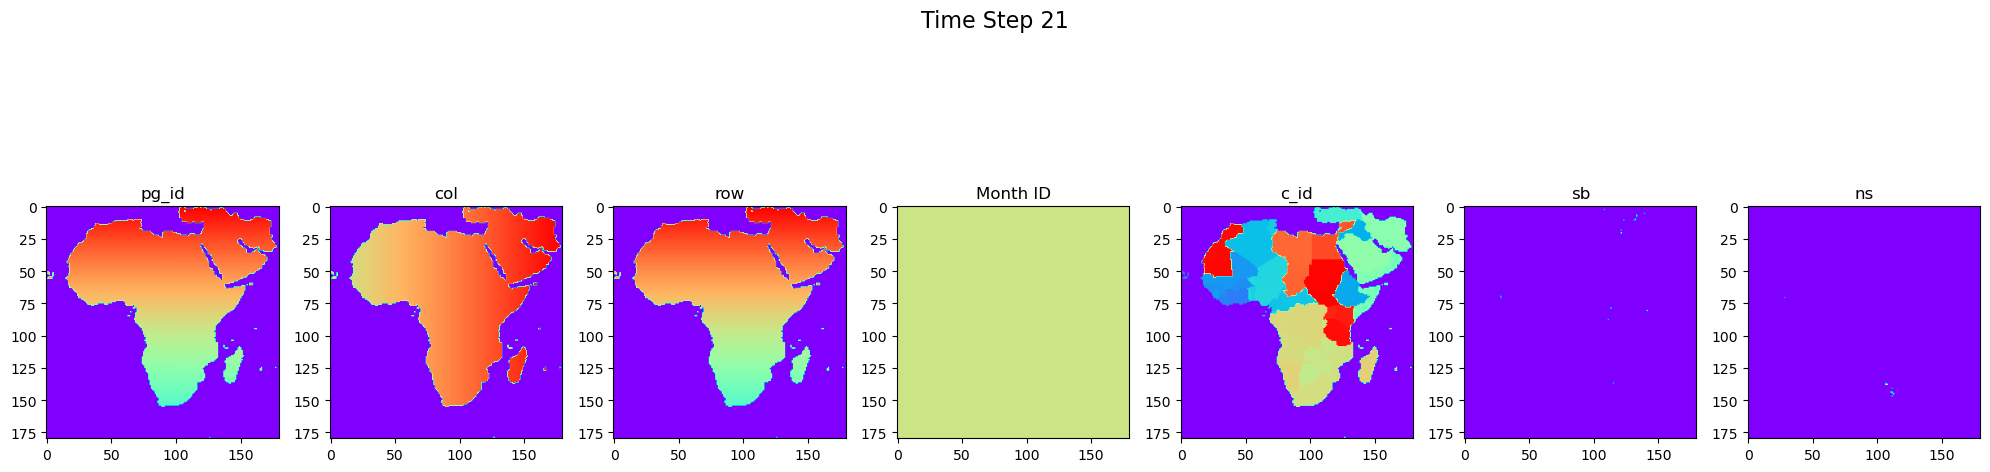

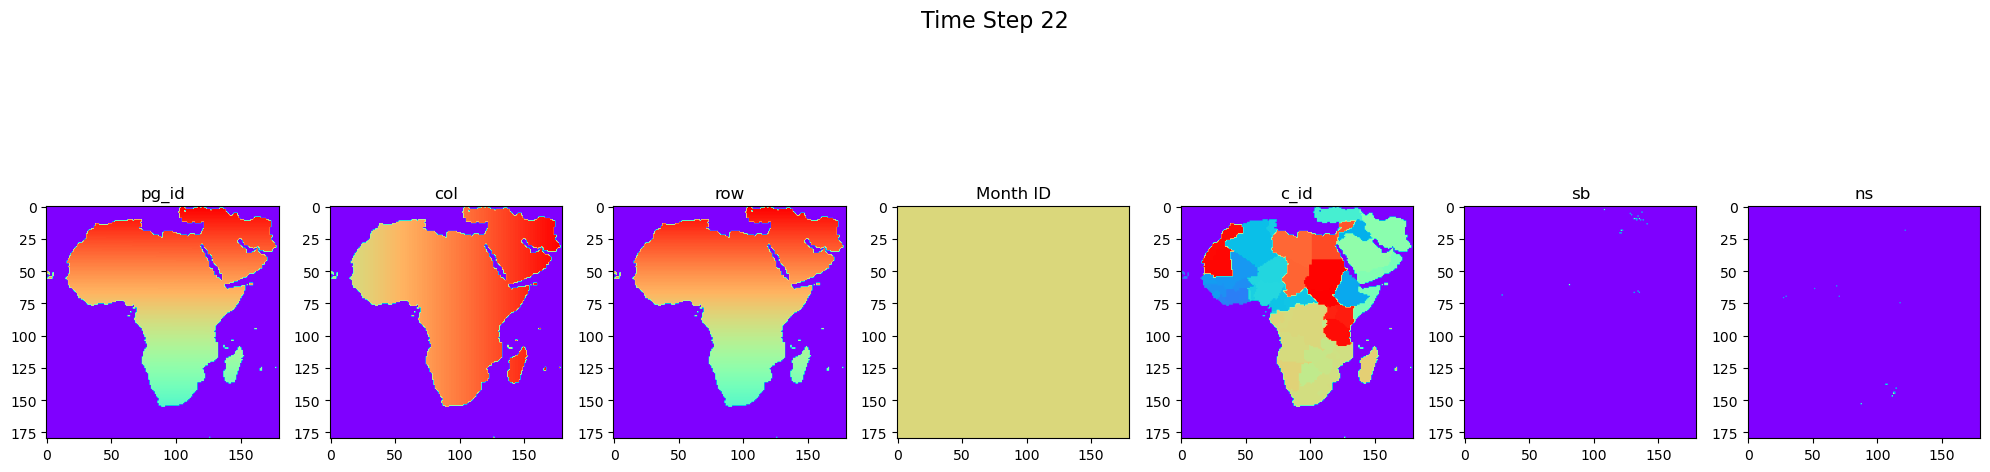

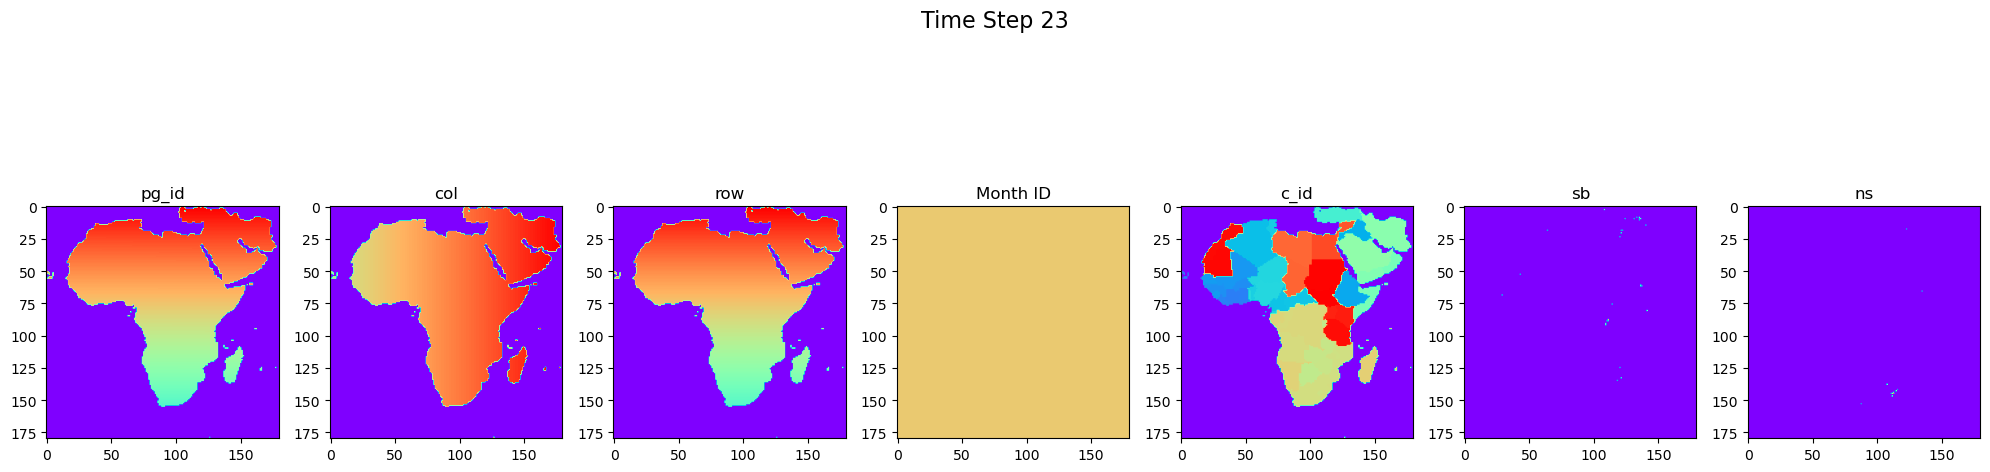

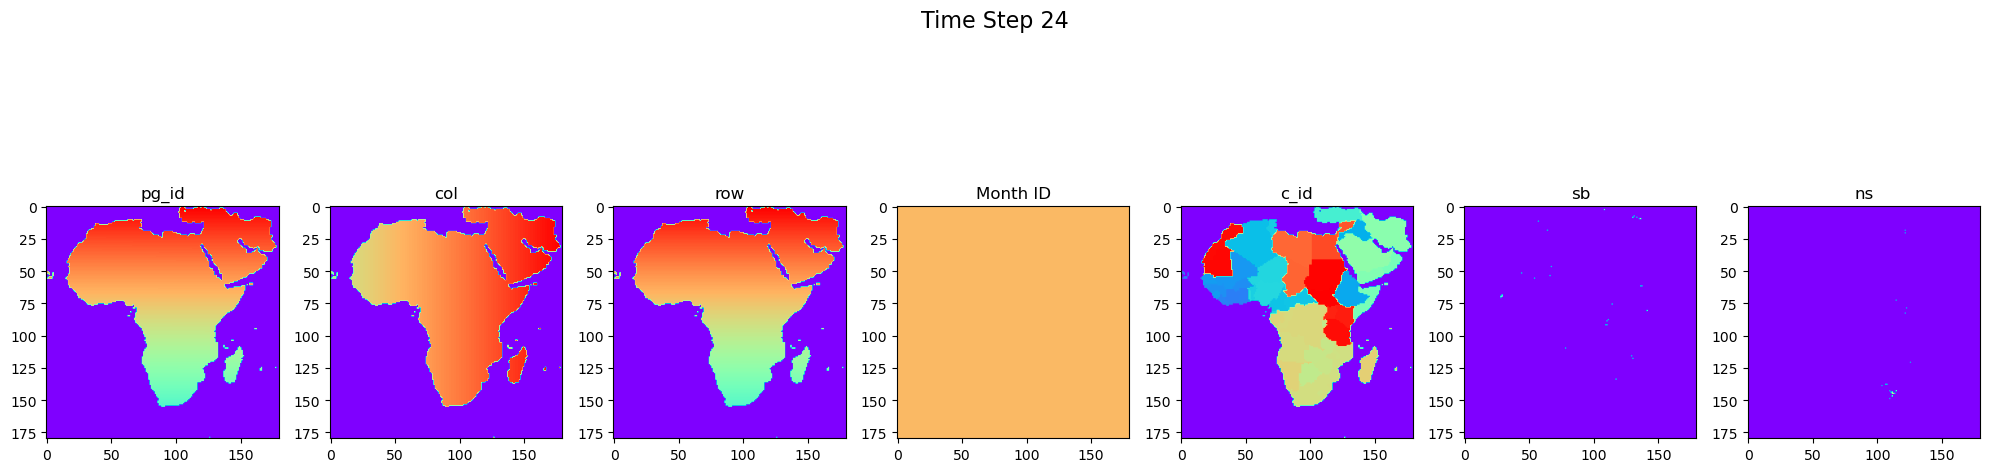

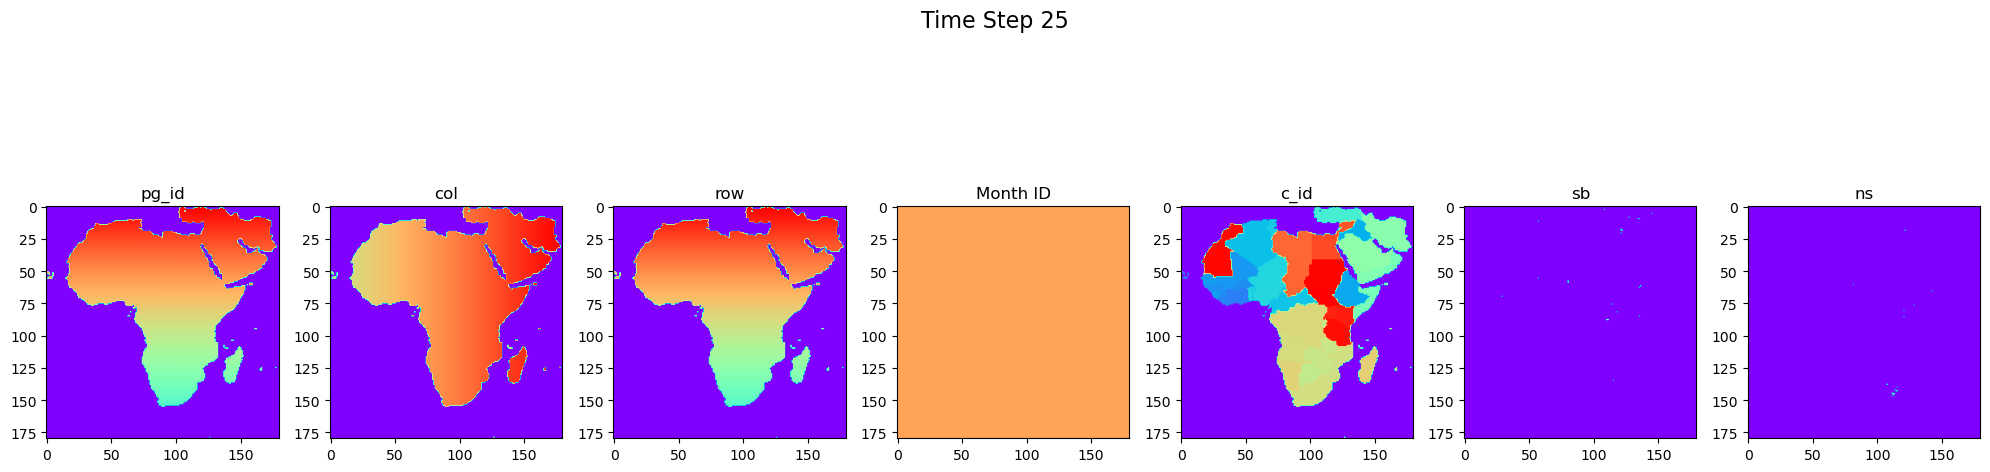

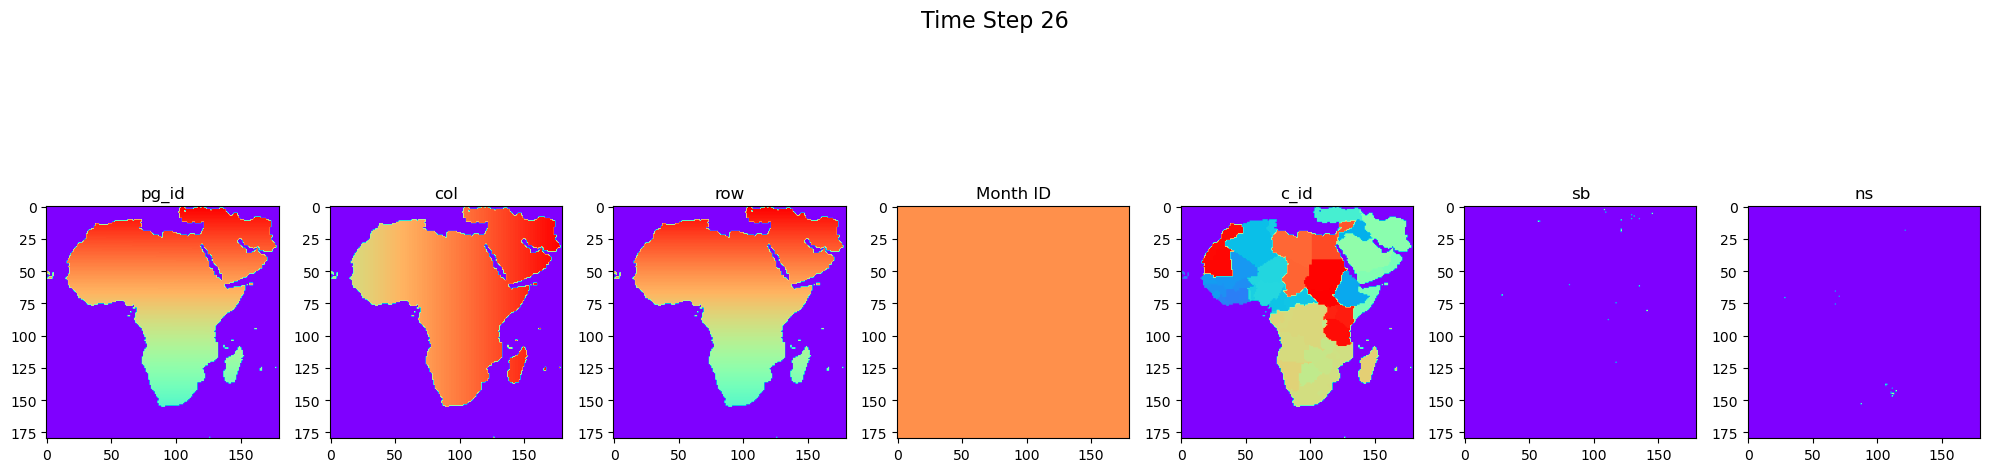

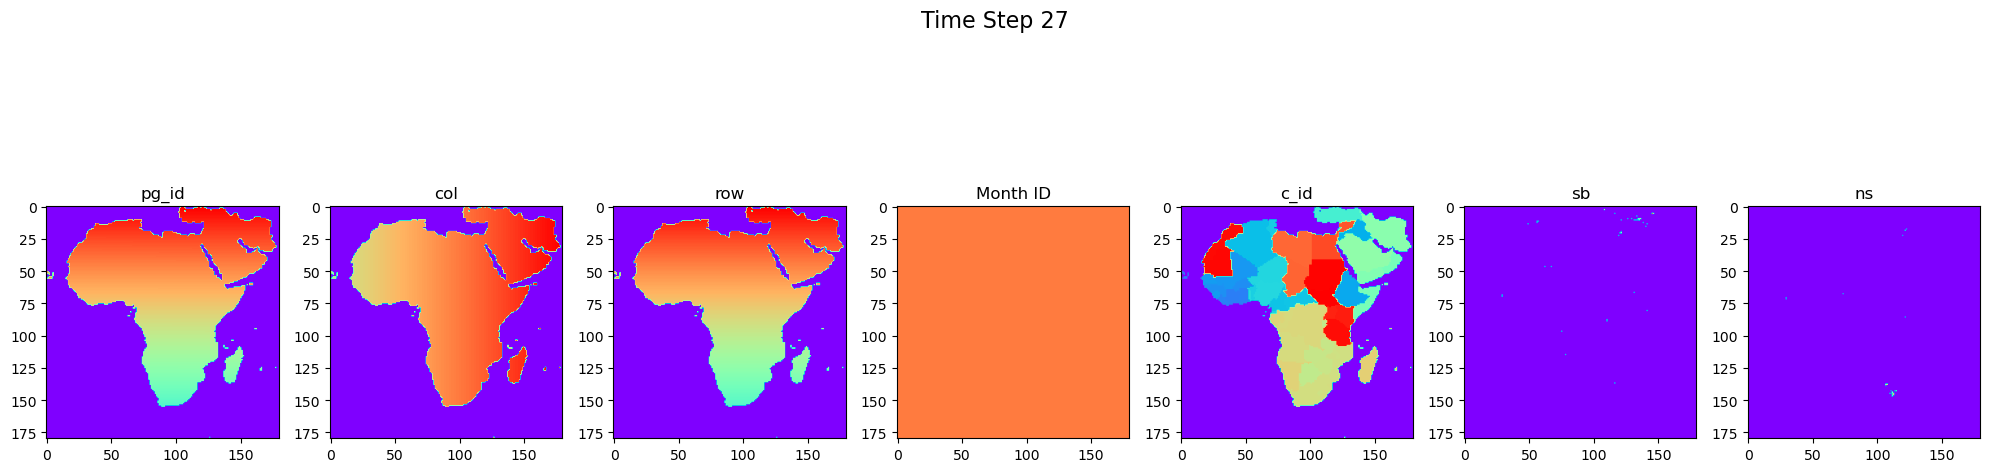

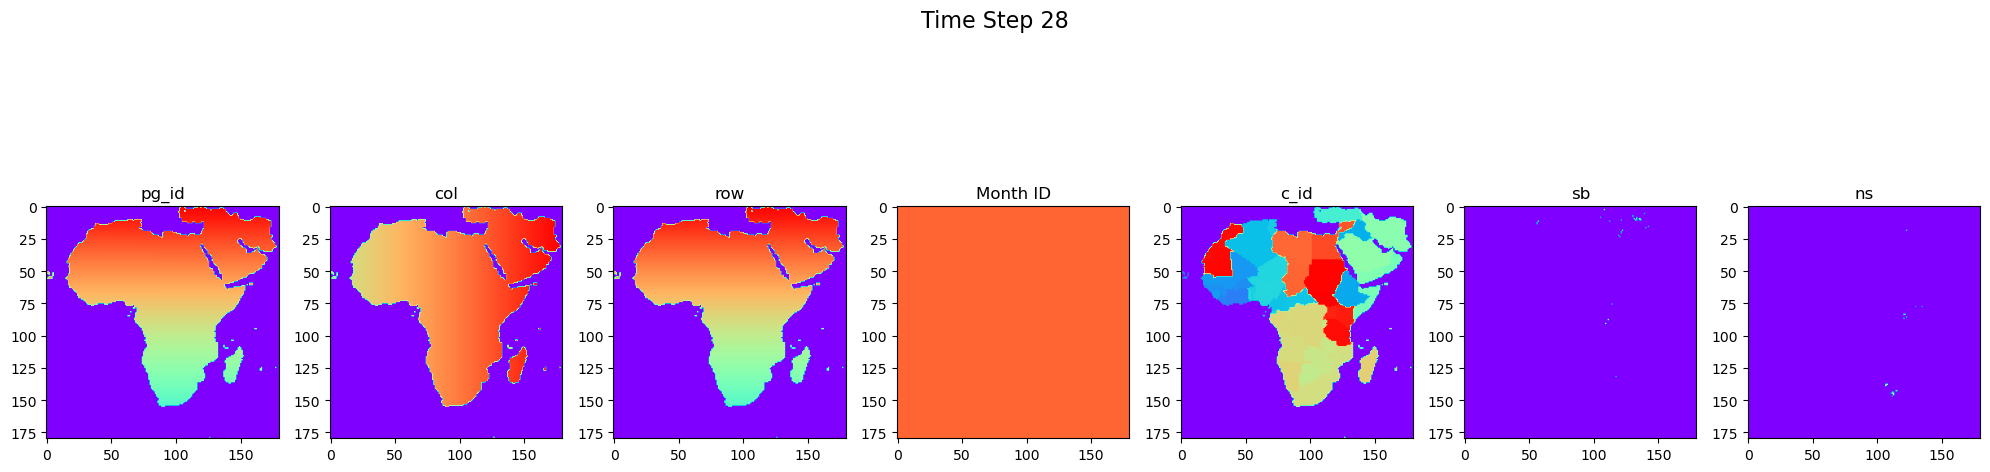

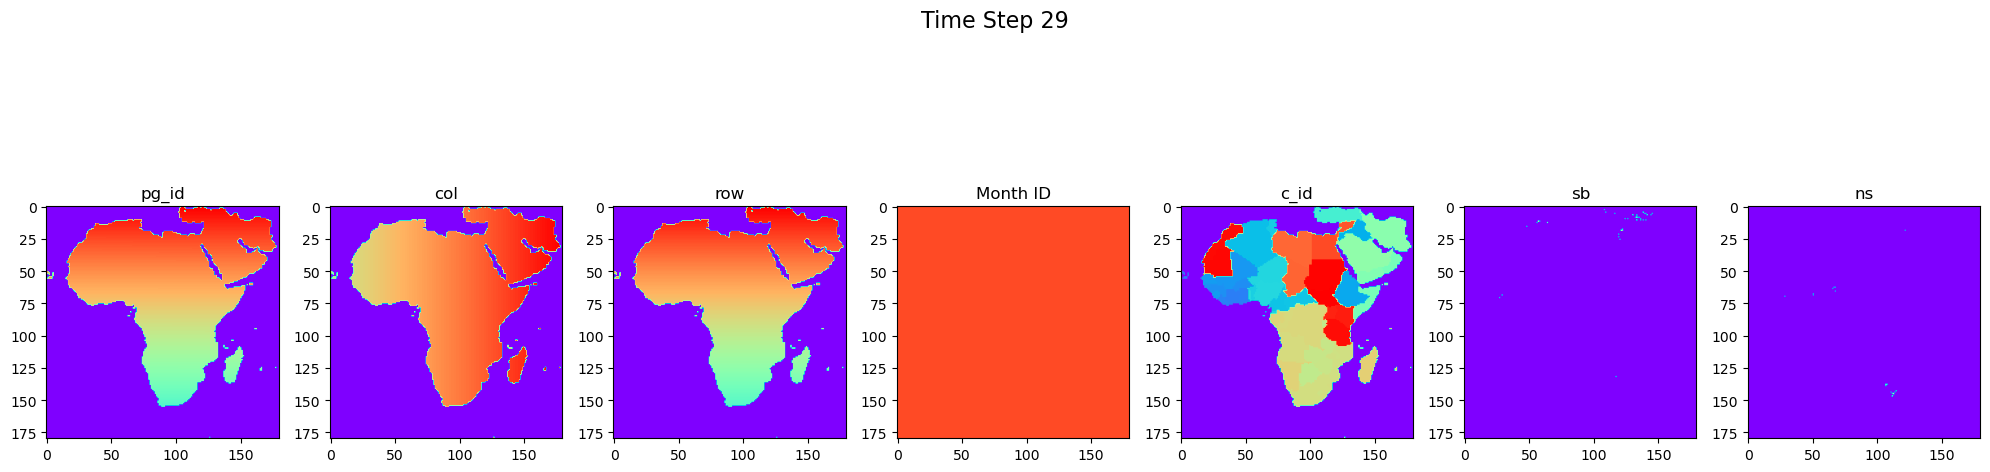

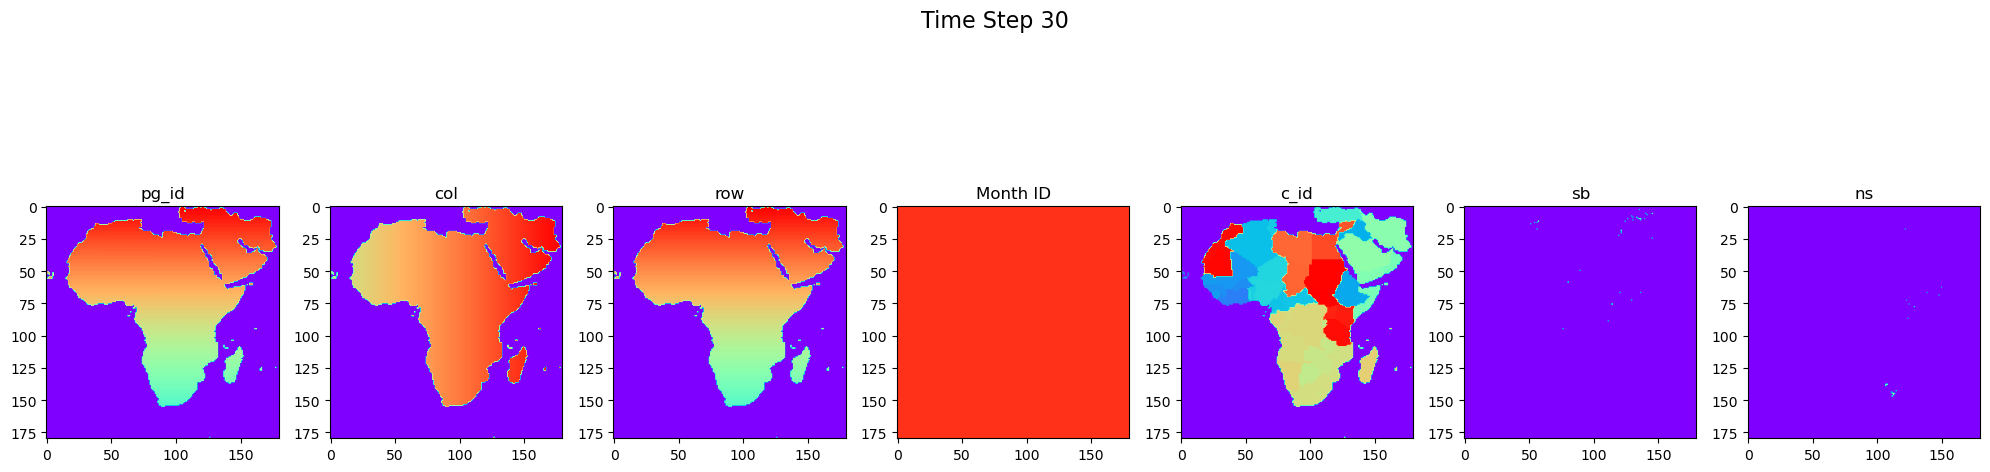

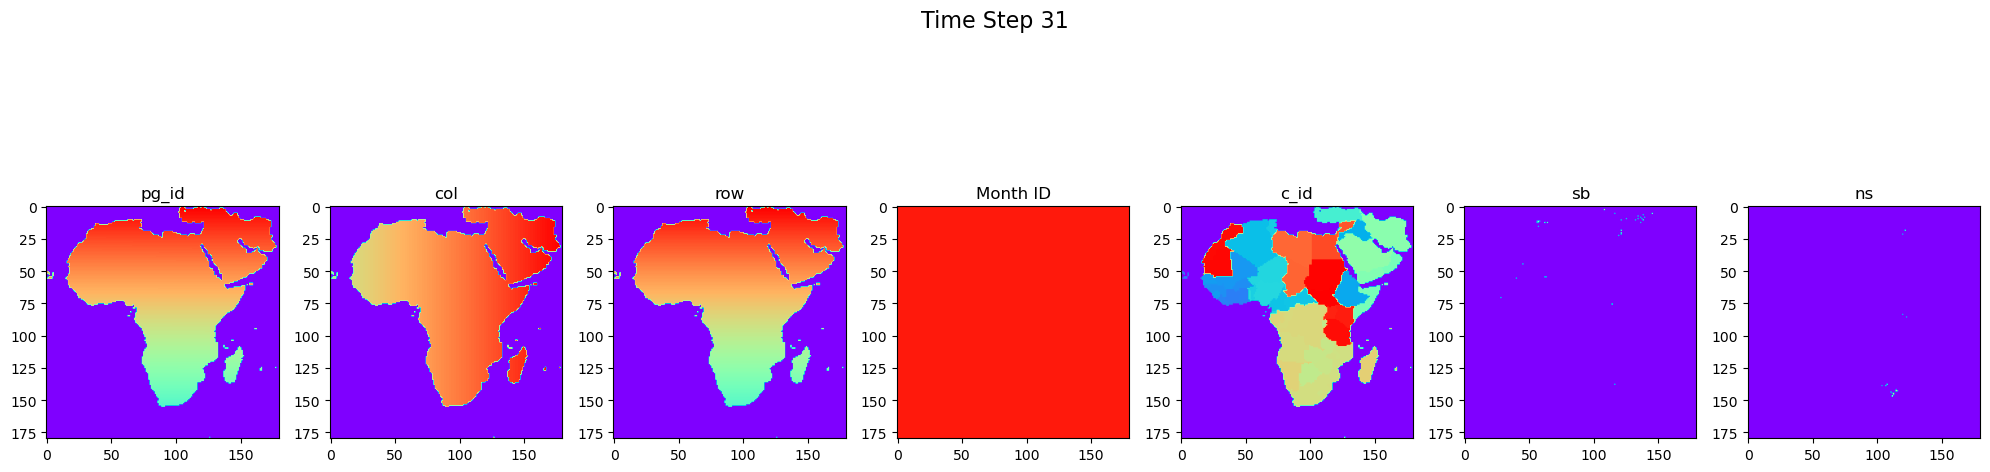

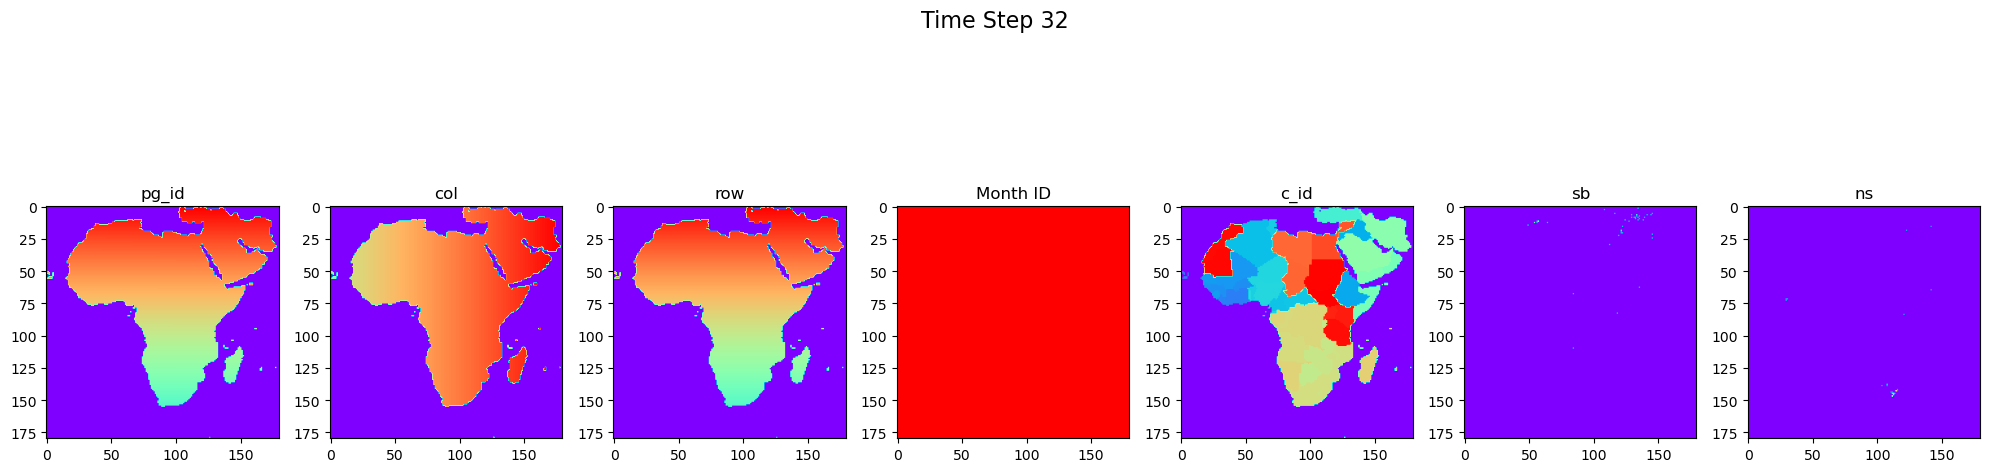

In [13]:
month_range = 32

vol_fake = generate_fake_vol(vol, month_range=month_range)

#print shape of vol_fake
print(vol_fake.shape)

# make the forecast storage volume
forecast_storage_vol = make_forecast_storage_vol(df, month_range=month_range)

#print shape of forecast_storage_vol
print(forecast_storage_vol.shape)

# merge the forecast storage volume with the forecast volume
full_vol = merge_vol(forecast_storage_vol, vol_fake)

#print shape of full_vol
print(full_vol.shape)

# plot the volume slices
plot_volume_slices(full_vol, num_slices=month_range)